Individual household electric power consumption

Background:

You are working for an energy company interested in understanding household electricity consumption patterns. The company aims to identify factors influencing electricity usage and develop predictive models to forecast future consumption accurately.

DataSet:

You can use the "Household Power Consumption" dataset, which contains measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. The dataset is publicly available from the UCI Machine Learning Repository: 

https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption 

Deliverables:

1- Jupyter Notebook or equivalent documenting the entire data science pipeline, from data exploration to model deployment.

2- Presentation summarizing key findings, methodology, model performance, and recommendations for the energy company.

You will be assesed on the following points

In [227]:
import pandas as pd
import plotly.express as px
import numpy as np
import warnings
import matplotlib.pyplot as plt
import datetime
from xgboost import XGBRegressor

%matplotlib inline
warnings.filterwarnings("ignore")

1- Data Collection and Exploration:

1. **Date**: Date in format `dd/mm/yyyy`
2. **Time**: Time in format `hh:mm:ss`
3. **Global Active Power**: Household global minute-averaged active power (in kilowatt)
4. **Global Reactive Power**: Household global minute-averaged reactive power (in kilowatt)
5. **Voltage**: Minute-averaged voltage (in volt)
6. **Global Intensity**: Household global minute-averaged current intensity (in ampere)
7. **Sub Metering 1**: Energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven, and a microwave (hot plates are not electric but gas-powered).
8. **Sub Metering 2**: Energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing machine, a tumble dryer, a refrigerator, and a light.
9. **Sub Metering 3**: Energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water heater and an air conditioner.

In [298]:
def load_data(filepath):
    df = pd.read_csv(file_path, sep=';', decimal='.', parse_dates=[['Date', 'Time']], low_memory=False)
    df.rename(columns={'Date_Time': 'Timestamp'}, inplace=True)
    numeric_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                      'Global_intensity', 'Sub_metering_1', 'Sub_metering_2']
    print(df.shape)
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col].replace('?', np.nan), errors='coerce')
        print(f"\nColumn: {col}")
        print(f"Data type: {df[col].dtype}")
        print(f"Number of NaN values: {df[col].isna().sum()}")
        print(f"Sample values: {df[col].head().tolist()}")
    
    return df

filepath = 'household_power_consumption.txt'
df = load_data(filepath)

(2075259, 8)

Column: Global_active_power
Data type: float64
Number of NaN values: 25979
Sample values: [4.216, 5.36, 5.374, 5.388, 3.666]

Column: Global_reactive_power
Data type: float64
Number of NaN values: 25979
Sample values: [0.418, 0.436, 0.498, 0.502, 0.528]

Column: Voltage
Data type: float64
Number of NaN values: 25979
Sample values: [234.84, 233.63, 233.29, 233.74, 235.68]

Column: Global_intensity
Data type: float64
Number of NaN values: 25979
Sample values: [18.4, 23.0, 23.0, 23.0, 15.8]

Column: Sub_metering_1
Data type: float64
Number of NaN values: 25979
Sample values: [0.0, 0.0, 0.0, 0.0, 0.0]

Column: Sub_metering_2
Data type: float64
Number of NaN values: 25979
Sample values: [1.0, 1.0, 2.0, 1.0, 1.0]


In [299]:
df_copy = df.copy()

In [300]:
df_copy['Sub_metering_other'] = (df_copy['Global_active_power'] * 1000 / 60) - df_copy['Sub_metering_1'] - df_copy['Sub_metering_2'] - df_copy['Sub_metering_3']

In [301]:
plot_data = pd.DataFrame({
    'Category': ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_other'],
    'Value': [
        df_copy['Sub_metering_1'].sum(),
        df_copy['Sub_metering_2'].sum(),
        df_copy['Sub_metering_3'].sum(),
        df_copy['Sub_metering_other'].sum()
    ]
})

# Plot the bar plot
fig = px.bar(plot_data, x='Category', y='Value', title='Sub Metering Comparison',
             labels={"Value": "Energy Consumption (Wh)", "Category": "Metering Type"})
fig.update_layout(template="plotly_white")
fig.show()

In [306]:
df_copy['Hour'] = df_copy['Timestamp'].dt.hour
hourly_data = df_copy.groupby('Hour')['Global_active_power'].mean().reset_index()
fig = px.bar(hourly_data, x='Hour', y='Global_active_power',
             title='Hourly Global Active Power Consumption',
             labels={'Global_active_power': 'Energy Consumption (kW)', 'Hour': 'Hour of the Day'},
             template='plotly_white')

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [308]:
df_copy['month'] = df_copy['Timestamp'].dt.month
hourly_data = df_copy.groupby('month')['Global_active_power'].mean().reset_index()
fig = px.bar(hourly_data, x='month', y='Global_active_power',
             title='Monthly Global Active Power Consumption',
             labels={'Global_active_power': 'Energy Consumption (kW)', 'month': 'Month'},
             template='plotly_white')

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [ ]:
df_copy['quarter'] = df_copy['Timestamp'].dt.quarter
hourly_data = df_copy.groupby('quarter')['Global_active_power'].mean().reset_index()
fig = px.bar(hourly_data, x='quarter', y='Global_active_power',
             title='Quarterly Global Active Power Consumption',
             labels={'Global_active_power': 'Energy Consumption (kW)', 'quarter': 'Quarter'},
             template='plotly_white')

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Timestamp              datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [109]:
full_date_range = pd.date_range(start=df['Timestamp'].min(), end=df['Timestamp'].max(), freq='T')
unique_timestamps = pd.to_datetime(df['Timestamp']).unique()
missing_dates = full_date_range.difference(unique_timestamps)

# Print missing dates if any
if len(missing_dates) > 0:
    print(f"Missing timestamps: {missing_dates}")
else:
    print("All timestamps are covered.")

All timestamps are covered.


In [110]:
df.isna().sum()

Timestamp                    0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [111]:
m, n = df.shape
df_per = (df.isnull().sum().sum())/m
col_pers = {}
for i in df.columns:
    col_pers[i] = (df[i].isnull().sum())/m

print(df_per)
print(col_pers)

0.08762906220380204
{'Timestamp': 0.0, 'Global_active_power': 0.012518437457686004, 'Global_reactive_power': 0.012518437457686004, 'Voltage': 0.012518437457686004, 'Global_intensity': 0.012518437457686004, 'Sub_metering_1': 0.012518437457686004, 'Sub_metering_2': 0.012518437457686004, 'Sub_metering_3': 0.012518437457686004}


In [112]:
# P = V × I - P = V × I × cos(φ)
# From this cell, we can deduce that we only don't need both Voltage and Global_intensity since our goal is only forecasting

def calculate_power(df):
    df_clean = df.dropna(subset=['Voltage', 'Global_intensity', 'Global_active_power'])
    df_clean['calculated_power'] = df_clean['Voltage'] * df_clean['Global_intensity'] / 1000
    apparent_power = df_clean['Voltage'] * df_clean['Global_intensity'] / 1000
    df_clean['power_factor'] = np.where(apparent_power != 0,
                                       df_clean['Global_active_power'] / apparent_power,
                                       0)
    df_clean['calculated_power_with_factor'] = df_clean['calculated_power'] * df_clean['power_factor']
    return df_clean

def validate_power(df):
    # Check if values are equal (within a small tolerance)
    is_equal = np.isclose(df['calculated_power_with_factor'], df['Global_active_power'], rtol=1e-5)
    
    print("\nValidation Results:")
    print(f"Total samples: {len(df)}")
    print(f"Matching samples: {sum(is_equal)}")
    print(f"Non-matching samples: {len(df) - sum(is_equal)}")
    
    if not all(is_equal):
        print("\nExamples of non-matching values:")
        non_matching = df[~is_equal][['Global_active_power', 'calculated_power_with_factor']].head()
        print(non_matching)

df_with_power = calculate_power(df)
validate_power(df_with_power)


Validation Results:
Total samples: 2049280
Matching samples: 2049280
Non-matching samples: 0


#### We can conclude the following for forecasting:
1. Dropping both Voltage and Global_intensity
2. We don't need sub_metering devices because we are interested in the total power consumption which is in Global_active_power
3. We don't need Global_reactive_power because it's just a component for regulations and not in consumption

2- Data Preprocessing:

In [140]:
def inspect_na_global_active_power(df):
    df_copy = df[['Timestamp', 'Global_active_power']]
    na_rows = df_copy[df_copy['Global_active_power'].isna()]
    result = []
    for index in na_rows.index:
        previous_row = df_copy.iloc[index-1] if index-1 >= 0 else None
        next_row = df_copy.iloc[index+1] if index+1 < len(df_copy) else None
        result.append((previous_row, df_copy.iloc[index], next_row))
    return result

na_surroundings = inspect_na_global_active_power(df)

In [153]:
def preprocess_data(df):
    def impute_na_with_closest(df, column):
        df_copy = df.copy()

        for index in range(1, len(df_copy)-1):
            if pd.isna(df_copy.loc[index, column]):
                # Look backwards for the closest non-NaN value
                prev_index = index - 1
                while prev_index >= 0 and pd.isna(df_copy.loc[prev_index, column]):
                    prev_index -= 1
                prev_value = df_copy.loc[prev_index, column] if prev_index >= 0 else None

                # Look forwards for the closest non-NaN value
                next_index = index + 1
                while next_index < len(df_copy) and pd.isna(df_copy.loc[next_index, column]):
                    next_index += 1
                next_value = df_copy.loc[next_index, column] if next_index < len(df_copy) else None

                # If both previous and next values are found, impute the mean
                if pd.notna(prev_value) and pd.notna(next_value):
                    df_copy.loc[index, column] = np.mean([prev_value, next_value])

        return df_copy

    df_copy = df.copy()
    df_copy.drop(['Global_reactive_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Global_intensity', 'Voltage'], axis=1, inplace=True)
    print(df_copy.isna().sum())
    # For the sake of the training and all, a simple imputation will be set
    df_imputed = impute_na_with_closest(df_copy, 'Global_active_power')
    print(df_imputed.isna().sum())
    df_imputed.set_index('Timestamp', inplace=True)
    df_resampled = df_imputed.resample('H').sum()
    df_resampled.reset_index(inplace=True)
    return df_resampled

df_resampled = preprocess_data(df)

Timestamp                  0
Global_active_power    25979
dtype: int64
Timestamp              0
Global_active_power    0
dtype: int64


In [155]:
df_resampled.shape

(34589, 2)

3- Feature Engineering:

#### For this data since it has a single column and not much features, we can use either prophet or tree based modol approach

In [235]:
def decomposeTimeStamp(input_df: pd.DataFrame) -> pd.DataFrame:
    import datetime

    def date_components(timestamp):
        def _cyclical_features(timestamp):
            def _cyclical_feature(value: int, max_value: int):
                return (
                    np.sin(2 * np.pi * value / max_value),
                    np.cos(2 * np.pi * value / max_value)
                )
            
            hour_sin, hour_cos = _cyclical_feature(timestamp.hour, 24)
            dow_sin, dow_cos = _cyclical_feature(timestamp.dayofweek, 7)
            days_in_year = 366 if timestamp.is_leap_year else 365
            doy_sin, doy_cos = _cyclical_feature(timestamp.dayofyear, days_in_year)
            dom_sin, dom_cos = _cyclical_feature(timestamp.day, timestamp.days_in_month)
            moy_sin, moy_cos = _cyclical_feature(timestamp.month, 12)
            return (hour_sin, hour_cos,
                    dow_sin, dow_cos, 
                    doy_sin, doy_cos, 
                    dom_sin, dom_cos, 
                    moy_sin, moy_cos)

        year, month = np.int16(timestamp.year), np.int8(timestamp.month)
        week_number, day_of_week = np.int8(timestamp.strftime("%U")), np.int8(timestamp.dayofweek)
        day = np.int8(timestamp.day)
        hour = np.int8(timestamp.hour)
        hour_sin, hour_cos, dow_sin, dow_cos, doy_sin, doy_cos, dom_sin, dom_cos, moy_sin, moy_cos = _cyclical_features(timestamp)
        is_month_start, is_month_end = np.int8(timestamp.is_month_start), np.int8(timestamp.is_month_end)  
        quarter = np.int8(timestamp.quarter)
        semester = np.int8(1 if quarter in [1, 2] else 2)
        is_workday = timestamp.weekday() < 5
        is_working_hour = is_workday and (9 <= timestamp.hour < 17)
        time_label = (1 if 5 <= timestamp.hour < 12 else  # Morning
                    2 if 12 <= timestamp.hour < 17 else  # Afternoon
                    3 if 17 <= timestamp.hour < 22 else  # Evening
                    4)
                        
        return {
            'year': year, 'month': month, 'hour': hour, 'day': day, 
            'hour_sin': hour_sin, 'hour_cos': hour_cos,
            'dow_sin': dow_sin, 'dow_cos': dow_cos, 'doy_sin': doy_sin, 'doy_cos': doy_cos, 
            'dom_sin': dom_sin, 'dom_cos': dom_cos, 'moy_sin': moy_sin, 'moy_cos': moy_cos,
            'week_number': week_number, 'day_of_week': day_of_week, 'is_month_start': is_month_start, 'time_label': time_label,
            'is_month_end': is_month_end, 'quarter': quarter, 'semester': semester, 'is_workday': is_workday, 'is_working_hour': is_working_hour, 
        }
    
    def georgian_date_decomposition(unique_timestamps):
        data = []
        for current_timestamp in unique_timestamps:
            decomposed_timestamp = date_components(current_timestamp)
            decomposed_timestamp['Timestamp'] = current_timestamp
            data.append(decomposed_timestamp)
        return pd.DataFrame(data) 

    def getCombinations(input_df):
        unique_timestamps = input_df['Timestamp'].unique()
        unique_timestamps = sorted(unique_timestamps)
        return unique_timestamps

    unique_timestamps = getCombinations(input_df)
    georgian_date_df = georgian_date_decomposition(unique_timestamps)
    input_df = pd.merge(left=input_df, right=georgian_date_df, on=['Timestamp'], how='left')
    return input_df

In [244]:
def featureEngineering(input_df, target_column):
    from functools import partial

    LAGS = [1, 2, 3, 24, 48]
    WINDOWS = [3, 8, 12, 24, 48]
    QUANTILES = [0.25, 0.5, 0.75]
    SPANS = [10, 50, 100]
    def weighted_mean(x, weights):
        return (weights * x).sum() / weights.sum()

    def weighted_std(x, weights):
        mean_w = weighted_mean(x, weights=weights)
        var_w = (weights * (x-mean_w)**2).sum()/weights.sum()
        return np.sqrt(var_w)

    def apply_lagged_features(df: pd.DataFrame) -> pd.DataFrame:
        """Calculate lagged features"""
        for lag in LAGS:
            df[f'{target_column}_lag_{lag}'] = df[target_column].shift(lag)
            df[f'{target_column}_diff_{lag}'] = df[target_column].diff(lag).shift(1)
        return df

    def apply_rolling_stats(df: pd.DataFrame) -> pd.DataFrame:
        for span in SPANS:
            df[f'{target_column}_ewm_{span}'] = (
                    df[target_column].ewm(span=span)
                    .agg('mean')
                    .shift(1)
                )

        for window in WINDOWS:
            for stat_type in ['min', 'max', 'weighted_mean', 'weighted_std']:
                weights = np.arange(1, window + 1)  # Create weights for each window
                if stat_type in ['weighted_mean', 'weighted_std']:
                    # Use partial to pass weights for weighted stats
                    stat_func = partial(weighted_mean if stat_type == 'weighted_mean' else weighted_std, weights=weights)
                    df[f'{target_column}_rolling_{stat_type}_{window}'] = (
                        df[target_column].rolling(window=window)
                        .apply(stat_func, raw=True)
                        .shift(1)
                    )
                else:
                    # Apply the default min/max aggregation
                    df[f'{target_column}_rolling_{stat_type}_{window}'] = (
                        df[target_column].rolling(window=window)
                        .agg(stat_type)
                        .shift(1)
                    )
                
                for quantile in QUANTILES:
                    df[f'{target_column}_rolling_quantile_{quantile}_{window}'] = (
                        df[target_column].rolling(window=window)
                        .quantile(quantile)
                        .shift(1)
                    )

        return df

    operations = [
        apply_lagged_features,
        apply_rolling_stats,
    ]

    df_processed = input_df.reset_index(drop=True)
    for operation in operations:
        df_processed = operation(df_processed)
    df_processed.fillna(-1, inplace=True)
    return df_processed

4- Model Selection and Training:

In [251]:
cutoff_timestamp = datetime.datetime(2010, 11, 25)
cutoff_timestamp = cutoff_timestamp.replace(hour=0, minute=0, second=0, microsecond=0)
traindata = df_resampled[df_resampled.Timestamp < cutoff_timestamp]
testdata = df_resampled[df_resampled.Timestamp >= cutoff_timestamp]

In [237]:
xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "verbosity": 0,
    "booster": "gbtree",
    "learning_rate": 0.05,
    "max_depth": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "n_estimators": 1000,
    "seed": 42,
    "gamma": 0,
    "min_child_weight": 1
}

In [249]:
def train_pipeline(traindata):
    target = "Global_active_power"
    decomposed_df = decomposeTimeStamp(traindata)
    processed_df = featureEngineering(decomposed_df, target)
    predictors = [col for col in processed_df.columns if col not in ['Global_active_power', 'hour', 'Timestamp', 'day_of_week', 'day', 'month']]
    model = XGBRegressor(**xgb_params)
    model.fit(processed_df[predictors], processed_df[target])
    return model, predictors, target

In [250]:
model, predictors, target = train_pipeline(traindata=traindata)

['year', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'dom_sin', 'dom_cos', 'moy_sin', 'moy_cos', 'week_number', 'is_month_start', 'time_label', 'is_month_end', 'quarter', 'semester', 'is_workday', 'is_working_hour', 'Global_active_power_lag_1', 'Global_active_power_diff_1', 'Global_active_power_lag_2', 'Global_active_power_diff_2', 'Global_active_power_lag_3', 'Global_active_power_diff_3', 'Global_active_power_lag_24', 'Global_active_power_diff_24', 'Global_active_power_lag_48', 'Global_active_power_diff_48', 'Global_active_power_ewm_10', 'Global_active_power_ewm_50', 'Global_active_power_ewm_100', 'Global_active_power_rolling_min_3', 'Global_active_power_rolling_quantile_0.25_3', 'Global_active_power_rolling_quantile_0.5_3', 'Global_active_power_rolling_quantile_0.75_3', 'Global_active_power_rolling_max_3', 'Global_active_power_rolling_weighted_mean_3', 'Global_active_power_rolling_weighted_std_3', 'Global_active_power_rolling_min_8', 'Global_active_power_rolli

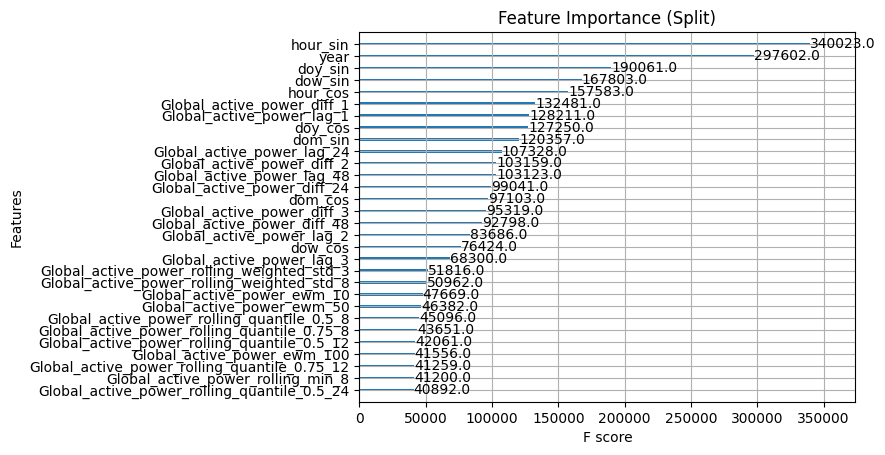

In [257]:
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt


plot_importance(model, importance_type='weight', title='Feature Importance (Split)', show_values=True, max_num_features=30)
plt.show()


5- Model Evaluation:

In [273]:
def recursiveForecast(input_df, start_predict_timestamp, steps, model, predictors, target_column):
    from tqdm import tqdm

    df = input_df.copy()
    forecast_results = pd.DataFrame()
    with tqdm(total=steps) as pbar:
        for step in range(steps):
            current_timestamp = start_predict_timestamp + pd.DateOffset(hours=step)
            pbar.set_description(f"Predicting for {current_timestamp}")
            df_subset = df[df['Timestamp'] <= current_timestamp].reset_index(drop=True)
            df_subset_processed = featureEngineering(df_subset, target_column)
            last_row = df_subset_processed[predictors].iloc[-1].to_numpy().reshape(1, -1)
            power_pred = np.abs(np.round(model.predict(last_row), 3))[0]
            df.at[df_subset.index[-1], target_column] = power_pred
            pbar.update(1)

    forecast_results = df[df['Timestamp'] >= start_predict_timestamp][['Timestamp', target]].reset_index(drop=True)
    forecast_results.rename(columns={target: 'yhat'}, inplace=True)
    return forecast_results

def predict_pipeline(traindata, testdata, start_predict_timestamp, steps, model, predictors, target):
    y_test_true = testdata[target]
    x_test = testdata.drop(target, axis=1)
    x_test[target] = -1
    full_test = pd.concat([traindata, x_test])
    full_test_decomposed = decomposeTimeStamp(full_test)
    forecast_results = recursiveForecast(full_test_decomposed, start_predict_timestamp, steps, model, predictors, target)
    return forecast_results

In [274]:
start_predict_timestamp = cutoff_timestamp
steps = 46
forecast_results = predict_pipeline(traindata, testdata, start_predict_timestamp, steps, model, predictors, target)

Predicting for 2010-11-26 21:00:00: 100%|██████████| 46/46 [02:24<00:00,  3.15s/it]


In [275]:
merged_df = forecast_results.merge(df_resampled, on=["Timestamp"])

In [278]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score
)

class Metrics:
    @staticmethod
    def smape(y_true, y_pred):
        """Symmetric Mean Absolute Percentage Error (sMAPE)"""
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        both = np.abs(y_true) + np.abs(y_pred)
        idx = np.where(both==0)[0]
        y_true[idx]=1; y_pred[idx]=1
        return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    
    @staticmethod
    def sbm(y_true, y_pred):
        """Shopbrain Metric (SBM)"""
        denominator = np.maximum(np.abs(y_true), np.abs(y_pred))
        with np.errstate(divide='ignore', invalid='ignore'):
            sbm = np.abs(y_pred - y_true) / denominator * 100
            sbm = np.nan_to_num(sbm, nan=0.0)
        return sbm.mean()

    @staticmethod
    def mae(y_true, y_pred):
        """Mean Absolute Error (MAE) - from sklearn"""
        return mean_absolute_error(y_true, y_pred)
    
    @staticmethod
    def rmse(y_true, y_pred):
        """Root Mean Squared Error (RMSE) - from sklearn"""
        return np.sqrt(mean_squared_error(y_true, y_pred))
    
    @staticmethod
    def mape(y_true, y_pred):
        """Mean Absolute Percentage Error (MAPE) - from sklearn"""
        return mean_absolute_percentage_error(y_true, y_pred)
    
    @staticmethod
    def r2(y_true, y_pred):
        """Coefficient of Determination (R-squared) - from sklearn"""
        return r2_score(y_true, y_pred)

    @staticmethod
    def rmsle(y_true, y_pred):
        """Root Mean Squared Logarithmic Error (RMSLE)"""
        y_true = np.log1p(np.array(y_true))
        y_pred = np.log1p(np.array(y_pred))
        return np.sqrt(mean_squared_error(y_true, y_pred))

    @staticmethod
    def combined_metrics(y_true, y_pred):
        """Returns a dictionary with a combination of relevant time series metrics"""
        return {
            'sMAPE': round(Metrics.smape(y_true, y_pred), 3),
            'MAE': round(Metrics.mae(y_true, y_pred), 3),
            'RMSE': round(Metrics.rmse(y_true, y_pred), 3),
            'MAPE': round(Metrics.mape(y_true, y_pred), 3),
            'R²': round(Metrics.r2(y_true, y_pred), 3),
            'RMSLE': round(Metrics.rmsle(y_true, y_pred), 3)
        }

predict_metric = Metrics.combined_metrics(merged_df['Global_active_power'], merged_df['yhat'])
print(predict_metric)

{'sMAPE': 37.945, 'MAE': 22.434, 'RMSE': 31.856, 'MAPE': 1.492, 'R²': 0.434, 'RMSLE': 0.676}


In [277]:
fig = px.line(merged_df, x="Timestamp", y=["Global_active_power", "yhat"], title="Time Series Plot for Product Quantity",
              labels={"Global_active_power": "True Power Consumption", "yhat": "Predicted Power Consumption", "Timestamp": "Timestamp"})

fig.update_layout(template="plotly_white")
fig.show()

6- Model Deployment:

In [270]:
# This is just a simple example of deployment. I just had no time.

from pydantic import BaseModel
import asyncio

from fastapi import APIRouter, HTTPException
from fastapi.responses import JSONResponse

class ForecastRequest(BaseModel):
    start_predict_date: str # format "YYYY-MM-DD"
    hour: int
    steps: int

router = APIRouter()

@router.post("/forecast")
async def forecast(forecast_body: ForecastRequest):
    start_predict_date = forecast_body.start_predict_date
    hour = forecast_body.hour
    timestamp_str = f"{start_predict_date} {hour}:00:00"
    timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S")
    steps = forecast_body.steps
    try:
        loop = asyncio.get_event_loop()
        # we should have a main or function to fetch data
        forecast_results = predict_pipeline(traindata, testdata, start_predict_timestamp, steps, model, predictors, target)
        return JSONResponse(content={"message": "Forecasting completed successfully."},status_code=200)

    except Exception as e:
        return JSONResponse(content={"message": f"Errors occurred in forecasting worker processes: {e}"}, status_code=400)